# Scope

The objective of this notebook is to **analyze the different features extracted from forexfactory and dukascopy** in order to **take decisions during the modeling phase**:


- The goal of the classification model is to be able to predict, once the new is released, the impact that it will have on the market:  

    - No market impact, i.e., the EURUSD exchange rate won´t be highly affected by this release
    - High positive impact, i.e., positive pips variation in EURUSD
    - High negative impact, i.e., negative pips variation in EURUSD
    
    **key question:** which would be sensible threshold´s values for such classification? We need some exploratory analysis to find them out   

- Are there strong correlations between the features obtained from the release of news and the features from their corresponding market reaction?
   Our expectation is that, the higher the deviation from the forecasted value, the higher the market reaction. We need to validate that assumption

- Would it make sense to split the data into different clusters using non-supervised techniques before the classification modeling?
   
- Would it make sense to try to estimate pips variation?   


In [329]:
import pandas as pd
import numpy as np

In [330]:
%matplotlib inline 

In [331]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
df = pd.read_csv('../data/curated/features_news_USD_pair_EURUSD_2007_2018.csv')

In [332]:
df.head(2)

,datetime_gmt,actual,country,datetime,forecast,forecast_error,impact,new,previous,previous_error,week,forecast_error_diff,year,quarter,month,weekday,volatility_60_0_before,pips_agg_60_0_before,volatility_0_45_after,pips_agg_0_45_after,volatility_0_60_after,pips_agg_0_60_after,volatility_0_90_after,pips_agg_0_90_after,volatility_0_120_after,pips_agg_0_120_after,volatility_0_150_after,pips_agg_0_150_after,volatility_0_180_after,pips_agg_0_180_after,volatility_0_210_after,pips_agg_0_210_after,volatility_0_240_after,pips_agg_0_240_after,open_released,high_released,low_released,close_released,high_0_5_after,low_0_5_after,close_0_5_after,volatility_0_5_after,direction_candle_0_5_after,direction_agg_0_5_after,pips_agg_0_5_after,pips_candle_0_5_after,high_5_10_after,low_5_10_after,close_5_10_after,volatility_5_10_after,...,volatility_10_15_after,direction_candle_10_15_after,direction_agg_10_15_after,pips_agg_10_15_after,pips_candle_10_15_after,high_15_20_after,low_15_20_after,close_15_20_after,volatility_15_20_after,direction_candle_15_20_after,direction_agg_15_20_after,pips_agg_15_20_after,pips_candle_15_20_after,high_20_25_after,low_20_25_after,close_20_25_after,volatility_20_25_after,direction_candle_20_25_after,direction_agg_20_25_after,pips_agg_20_25_after,pips_candle_20_25_after,high_25_30_after,low_25_30_after,close_25_30_after,volatility_25_30_after,direction_candle_25_30_after,direction_agg_25_30_after,pips_agg_25_30_after,pips_candle_25_30_after,previous_value,previous_error_diff,total_error_diff,forecast_error_diff_std,forecast_error_diff_dir,forecast_error_diff_deviation,forecast_error_diff_upper_quantile,forecast_error_diff_lower_quantile,forecast_error_diff_oulier_class,previous_error_diff_std,previous_error_diff_dir,previous_error_diff_deviation,previous_error_diff_upper_quantile,previous_error_diff_lower_quantile,previous_error_diff_oulier_class,total_error_diff_std,total_error_diff_dir,total_error_diff_deviation,total_error_diff_upper_quantile,total_error_diff_lower_quantile,total_error_diff_oulier_class
0,2007-01-08 20:00:00+00:00,12.3B,USD,2007-01-08 15:00:00,5.4B,better,Low,Consumer Credit m/m,-1.3B,accurate,2,6.9,2007,1,1,0,14,4,9,-2,9,-1,15,-1,18,3,21,5,23,8,23,8,32,18,13018,13020,13016,13018,13022,13016,13019,6,0,0,1,0,13020,13016,13017,4,...,9,0,0,1,1,13021,13017,13020,4,0,0,2,2,13022,13016,13018,6,0,0,0,-2,13020,13015,13018,5,0,0,0,0,-1.3B,0.0,6.9,6.9,-1.0,1.0,6.9,6.9,0,0.0,-1.0,0.0,0.0,0.0,0,6.9,-1.0,1.0,6.9,6.9,0
1,2007-02-07 20:00:00+00:00,6.0B,USD,2007-02-07 15:00:00,7.0B,worse,Low,Consumer Credit m/m,13.7B,better,6,-1.0,2007,1,2,2,15,-11,10,-2,11,5,16,7,16,7,16,7,17,6,17,9,23,14,13007,13008,13002,13005,13006,13003,13006,3,0,0,1,1,13010,13004,13005,6,...,5,0,0,0,-2,13005,13001,13005,4,0,0,0,2,13005,13000,13002,5,0,0,-3,-3,13006,13001,13005,5,0,0,0,0,12.3B,1.4,0.4,-1.0,1.0,-1.0,-1.0,-1.0,0,1.4,1.0,1.0,1.4,1.4,0,0.4,1.0,1.0,0.4,0.4,0


Let´s ensure that there is not missing data 

In [333]:
df.isnull().sum().sum()

0

Let´s have a quick look to the data, to ensure that everthing looks as expected

In [334]:
df.describe()

,week,forecast_error_diff,year,quarter,month,weekday,volatility_60_0_before,pips_agg_60_0_before,volatility_0_45_after,pips_agg_0_45_after,volatility_0_60_after,pips_agg_0_60_after,volatility_0_90_after,pips_agg_0_90_after,volatility_0_120_after,pips_agg_0_120_after,volatility_0_150_after,pips_agg_0_150_after,volatility_0_180_after,pips_agg_0_180_after,volatility_0_210_after,pips_agg_0_210_after,volatility_0_240_after,pips_agg_0_240_after,open_released,high_released,low_released,close_released,high_0_5_after,low_0_5_after,close_0_5_after,volatility_0_5_after,direction_candle_0_5_after,direction_agg_0_5_after,pips_agg_0_5_after,pips_candle_0_5_after,high_5_10_after,low_5_10_after,close_5_10_after,volatility_5_10_after,direction_candle_5_10_after,direction_agg_5_10_after,pips_agg_5_10_after,pips_candle_5_10_after,high_10_15_after,low_10_15_after,close_10_15_after,volatility_10_15_after,direction_candle_10_15_after,direction_agg_10_15_after,pips_agg_10_15_after,pips_candle_10_15_after,high_15_20_after,low_15_20_after,close_15_20_after,volatility_15_20_after,direction_candle_15_20_after,direction_agg_15_20_after,pips_agg_15_20_after,pips_candle_15_20_after,high_20_25_after,low_20_25_after,close_20_25_after,volatility_20_25_after,direction_candle_20_25_after,direction_agg_20_25_after,pips_agg_20_25_after,pips_candle_20_25_after,high_25_30_after,low_25_30_after,close_25_30_after,volatility_25_30_after,direction_candle_25_30_after,direction_agg_25_30_after,pips_agg_25_30_after,pips_candle_25_30_after,previous_error_diff,total_error_diff,forecast_error_diff_std,forecast_error_diff_dir,forecast_error_diff_deviation,forecast_error_diff_upper_quantile,forecast_error_diff_lower_quantile,forecast_error_diff_oulier_class,previous_error_diff_std,previous_error_diff_dir,previous_error_diff_deviation,previous_error_diff_upper_quantile,previous_error_diff_lower_quantile,previous_error_diff_oulier_class,total_error_diff_std,total_error_diff_dir,total_error_diff_deviation,total_error_diff_upper_quantile,total_error_diff_lower_quantile,total_error_diff_oulier_class
count,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.00000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.00000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000,9667.000000
mean,26.502845,-0.132095,2012.585704,2.485052,6.473984,2.341988,34.877418,-0.475328,35.911244,-0.237819,39.760215,-0.275887,46.324092,-0.465398,52.016344,-0.239475,56.091755,-0.528292,59.416365,-0.295438,61.987173,-0.050274,64.464570,0.175649,12828.111203,12832.481639,12823.708596,12827.966380,12836.586014,12819.621806,12828.122272,16.964208,0.011482,0.010758,0.155891,0.163029,12834.231509,12821.747698,12827.944243,12.483811,-0.006620,0.003414,-0.022137,-0.172442,12833.610944,12822.388125,12828.089169,11.22282,0.004448,0.005379,0.122789,0.146788,12833.361229,12822.371263,12827.847005,10.989966,-0.006310,-0.012517,-0.119375,-0.257577,12832.833971,12822.643426,12827.786387,10.190545,-0.002896,-0.009931,-0.179994,-0.042205,12832.874418,12822.61291,12827.73

Paying attention to **"forecast_error_diff_deviation"**, we can see that the min = -143 and max = 72.   
It seems that there are outliers there, as we don´t expect such big deviations from the forecasted values. Let´s have a look

In [344]:
df[df['forecast_error_diff_deviation']>72]


,datetime_gmt,actual,country,datetime,forecast,forecast_error,impact,new,previous,previous_error,week,forecast_error_diff,year,quarter,month,weekday,volatility_60_0_before,pips_agg_60_0_before,volatility_0_45_after,pips_agg_0_45_after,volatility_0_60_after,pips_agg_0_60_after,volatility_0_90_after,pips_agg_0_90_after,volatility_0_120_after,pips_agg_0_120_after,volatility_0_150_after,pips_agg_0_150_after,volatility_0_180_after,pips_agg_0_180_after,volatility_0_210_after,pips_agg_0_210_after,volatility_0_240_after,pips_agg_0_240_after,open_released,high_released,low_released,close_released,high_0_5_after,low_0_5_after,close_0_5_after,volatility_0_5_after,direction_candle_0_5_after,direction_agg_0_5_after,pips_agg_0_5_after,pips_candle_0_5_after,high_5_10_after,low_5_10_after,close_5_10_after,volatility_5_10_after,...,volatility_10_15_after,direction_candle_10_15_after,direction_agg_10_15_after,pips_agg_10_15_after,pips_candle_10_15_after,high_15_20_after,low_15_20_after,close_15_20_after,volatility_15_20_after,direction_candle_15_20_after,direction_agg_15_20_after,pips_agg_15_20_after,pips_candle_15_20_after,high_20_25_after,low_20_25_after,close_20_25_after,volatility_20_25_after,direction_candle_20_25_after,direction_agg_20_25_after,pips_agg_20_25_after,pips_candle_20_25_after,high_25_30_after,low_25_30_after,close_25_30_after,volatility_25_30_after,direction_candle_25_30_after,direction_agg_25_30_after,pips_agg_25_30_after,pips_candle_25_30_after,previous_value,previous_error_diff,total_error_diff,forecast_error_diff_std,forecast_error_diff_dir,forecast_error_diff_deviation,forecast_error_diff_upper_quantile,forecast_error_diff_lower_quantile,forecast_error_diff_oulier_class,previous_error_diff_std,previous_error_diff_dir,previous_error_diff_deviation,previous_error_diff_upper_quantile,previous_error_diff_lower_quantile,previous_error_diff_oulier_class,total_error_diff_std,total_error_diff_dir,total_error_diff_deviation,total_error_diff_upper_quantile,total_error_diff_lower_quantile,total_error_diff_oulier_class
5691,2007-10-25 14:00:00+00:00,770K,USD,2007-10-25 10:00:00,770K,accurate,High,New Home Sales,735K,worse,43,0.0,2007,4,10,3,27,-15,24,-4,29,-11,42,-19,42,-15,42,-15,42,-10,42,-13,42,6,14315,14320,14313,14315,14318,14305,14308,13,0,0,-7,-6,14317,14305,14313,12,...,17,0,0,6,9,14323,14310,14313,13,0,0,-2,-7,14323,14309,14316,14,0,0,1,2,14319,14308,14311,11,0,0,-4,-6,795K,-60.0,-60.0,72.65191,-1.0,72.65,44.0,-66.0,0,23.543577,-1.0,-2.55,0.0,-22.0,1,81.747783,-1.0,-0.73,56.0,-88.0,0


In [345]:
df.iloc[list(range(5685,5692))]

,datetime_gmt,actual,country,datetime,forecast,forecast_error,impact,new,previous,previous_error,week,forecast_error_diff,year,quarter,month,weekday,volatility_60_0_before,pips_agg_60_0_before,volatility_0_45_after,pips_agg_0_45_after,volatility_0_60_after,pips_agg_0_60_after,volatility_0_90_after,pips_agg_0_90_after,volatility_0_120_after,pips_agg_0_120_after,volatility_0_150_after,pips_agg_0_150_after,volatility_0_180_after,pips_agg_0_180_after,volatility_0_210_after,pips_agg_0_210_after,volatility_0_240_after,pips_agg_0_240_after,open_released,high_released,low_released,close_released,high_0_5_after,low_0_5_after,close_0_5_after,volatility_0_5_after,direction_candle_0_5_after,direction_agg_0_5_after,pips_agg_0_5_after,pips_candle_0_5_after,high_5_10_after,low_5_10_after,close_5_10_after,volatility_5_10_after,...,volatility_10_15_after,direction_candle_10_15_after,direction_agg_10_15_after,pips_agg_10_15_after,pips_candle_10_15_after,high_15_20_after,low_15_20_after,close_15_20_after,volatility_15_20_after,direction_candle_15_20_after,direction_agg_15_20_after,pips_agg_15_20_after,pips_candle_15_20_after,high_20_25_after,low_20_25_after,close_20_25_after,volatility_20_25_after,direction_candle_20_25_after,direction_agg_20_25_after,pips_agg_20_25_after,pips_candle_20_25_after,high_25_30_after,low_25_30_after,close_25_30_after,volatility_25_30_after,direction_candle_25_30_after,direction_agg_25_30_after,pips_agg_25_30_after,pips_candle_25_30_after,previous_value,previous_error_diff,total_error_diff,forecast_error_diff_std,forecast_error_diff_dir,forecast_error_diff_deviation,forecast_error_diff_upper_quantile,forecast_error_diff_lower_quantile,forecast_error_diff_oulier_class,previous_error_diff_std,previous_error_diff_dir,previous_error_diff_deviation,previous_error_diff_upper_quantile,previous_error_diff_lower_quantile,previous_error_diff_oulier_class,total_error_diff_std,total_error_diff_dir,total_error_diff_deviation,total_error_diff_upper_quantile,total_error_diff_lower_quantile,total_error_diff_oulier_class
5685,2007-04-25 14:00:00+00:00,858K,USD,2007-04-25 10:00:00,890K,worse,High,New Home Sales,836K,worse,17,-32.0,2007,2,4,2,24,0,26,15,26,17,26,14,26,14,26,7,29,1,29,2,29,4,13639,13640,13635,13639,13655,13639,13655,16,1,1,16,16,13657,13651,13653,6,...,13,0,2,23,9,13665,13656,13657,9,0,1,18,-5,13658,13647,13656,11,0,1,17,-1,13660,13655,13655,5,0,1,16,-1,848K,-12.0,-44.0,-32.000000,-1.0,-32.00,-32.0,-32.0,0,-12.000000,-1.0,-12.00,-12.0,-12.0,0,-44.000000,-1.0,-44.00,-44.0,-44.0,0
5686,2007-05-24 14:00:00+00:00,981K,USD,2007-05-24 10:00:00,860K,better,High,New Home Sales,844K,worse,21,121.0,2007,2,5,3,33,3,30,-21,30,-14,30,-21,30,-21,30,-10,30,-13,30,-5,30,-6,13447,13447,13445,13447,13446,13424,13427,22,-1,-1,-20,-19,13429,13420,13422,9,...,9,0,-2,-27,-2,13424,13419,13421,5,0,-2,-26,-1,13424,13417,13423,7,0,-2,-24,3,13424,13422,13423,2,0,-2,-24,0,858K,-14.0,107.0,121.000000,-1.0,1.00,121.0,121.0,0,-14.000000,-1.0,-14.00,-14.0,-14.0,0,107.000000,-1.0,1.00,107.0,107.0,0
5687,2007-06-26 14:00:00+00:00,915K,USD,2007-06-26 10:00:00,922K,worse,High,New Home Sales,930K,worse,26,-7.0,2007,2,6,1,15,4,19,-11,19,-9,19,-6,19,-2,19,-8,19,-5,19,-2,19,-1,13468,13469,13467,13468,13474,13459,13460,15,0,0,-8,-9,13462,13457,13462,5,...,4,0,0,-7,-2,13463,13459,13459,4,0,0,-9,-2,13463,13459,13460,4,0,0,-8,1,13461,13459,13459,2,0,0,-9,-1,981K,-51.0,-58.0,119.221223,-1.0,-0.06,70.0,-137.0,0,23.222834,-1.0,-2.20,0.0,-14.0,1,129.256334,-1.0,-0.45,70.0,-140.0,0
5688,2007-07-26 14:00:00+00:00,834K,USD,2007-07-26 10:00:00,900K,worse,High,New Home Sales,893K,worse,30,-66.0,2007,3,7,3,39,4,27,2,27,3,36,-9,36,-2,58,7,63,34,63,17,63,30,13723,13726,13717,13723,13744,13723,13736,21,1,1,13,11,13739,13720,13726,19,...,13,0,0,2,0,13729,13721,13725,8,0,0,2,-2,13734,13721,13731,13,0,0,8,5,13733,13721,13725,12,0,0,2,-5,915K,-22.0,-88.0,108.502535,-1.0,-0.61,31.5,-84.5,0,25.723530,-1.0,-0.86,-6.0,-32.5,0,113.827940,-1.0,-0.77,13.0,-99.0,0
5689,2007-08-24 14:00:00

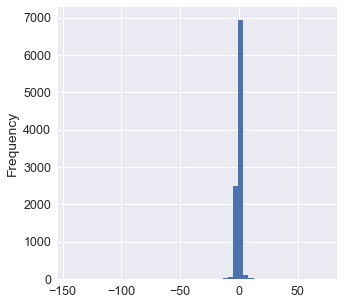

In [347]:
df['forecast_error_diff_deviation'].plot(kind='hist', bins = 50, figsize=(5,5))

Ok, we clearly have outliers here. Let´s see how many

In [369]:
len(df[df['forecast_error_diff_deviation'] < -6])

67

In [370]:
len(df[df['forecast_error_diff_deviation'] > 6])

38

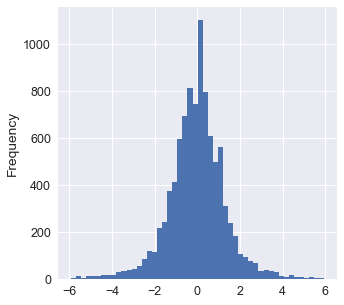

In [371]:
df_wo_outliers = df[df['forecast_error_diff_deviation'] > -6]
df_wo_outliers = df_wo_outliers[df_wo_outliers['forecast_error_diff_deviation'] < 6]
df_wo_outliers['forecast_error_diff_deviation'].plot(kind='hist', bins = 50, figsize=(5,5))

In [372]:
df_outliers = df[(df['forecast_error_diff_deviation'] < -6) | (df['forecast_error_diff_deviation'] > 6)] 



In [373]:
len(df_outliers)

105

In [374]:
df_outliers_by_datetime = df_outliers[['datetime_gmt','forecast_error_diff_deviation', 'pips_agg_25_30_after', 
                          'pips_agg_0_60_after', 'pips_agg_0_240_after']]

df_outliers_by_datetime = df_outliers_by_datetime.groupby('datetime_gmt', as_index=False).agg({'forecast_error_diff_deviation': 'sum',
                                                                                       'pips_agg_25_30_after': 'first',
                                                                                      'pips_agg_0_60_after': 'first',
                                                                                      'pips_agg_0_240_after': 'first'})

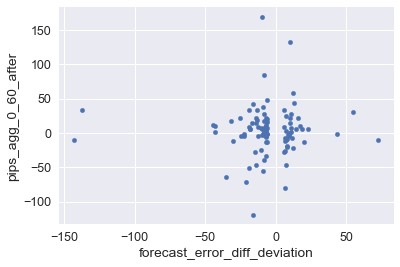

In [375]:
df_outliers_by_datetime.plot.scatter(x='forecast_error_diff_deviation', y='pips_agg_0_60_after')

First of all, we would like to have insights on how the publication of macro-economic news affect the market

In [376]:
df_wo_outliers_by_datetime = df_wo_outliers[['datetime_gmt','pips_agg_25_30_after', 'pips_agg_0_60_after','pips_agg_0_90_after','pips_agg_0_120_after',
                          'pips_agg_0_150_after','pips_agg_0_180_after','pips_agg_0_210_after','pips_agg_0_240_after']]

In [377]:
df_wo_outliers_by_datetime.head(2)

,datetime_gmt,pips_agg_25_30_after,pips_agg_0_60_after,pips_agg_0_90_after,pips_agg_0_120_after,pips_agg_0_150_after,pips_agg_0_180_after,pips_agg_0_210_after,pips_agg_0_240_after
0,2007-01-08 20:00:00+00:00,0,-1,-1,3,5,8,8,18
1,2007-02-07 20:00:00+00:00,0,5,7,7,7,6,9,14


As some news are released exactly at the same datetime, we need to group them

In [379]:
len(df_wo_outliers_by_datetime)

9560

In [380]:
df_wo_outliers_by_datetime = df_wo_outliers_by_datetime.groupby('datetime_gmt', as_index=False).first()


In [381]:
len(df_wo_outliers_by_datetime)

6301

In [382]:
df_wo_outliers_by_datetime.head(2)

,datetime_gmt,pips_agg_25_30_after,pips_agg_0_60_after,pips_agg_0_90_after,pips_agg_0_120_after,pips_agg_0_150_after,pips_agg_0_180_after,pips_agg_0_210_after,pips_agg_0_240_after
0,2007-01-08 20:00:00+00:00,0,-1,-1,3,5,8,8,18
1,2007-01-09 15:00:00+00:00,5,-3,-3,-11,0,11,7,6


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2f158b38>,
      dtype=object)

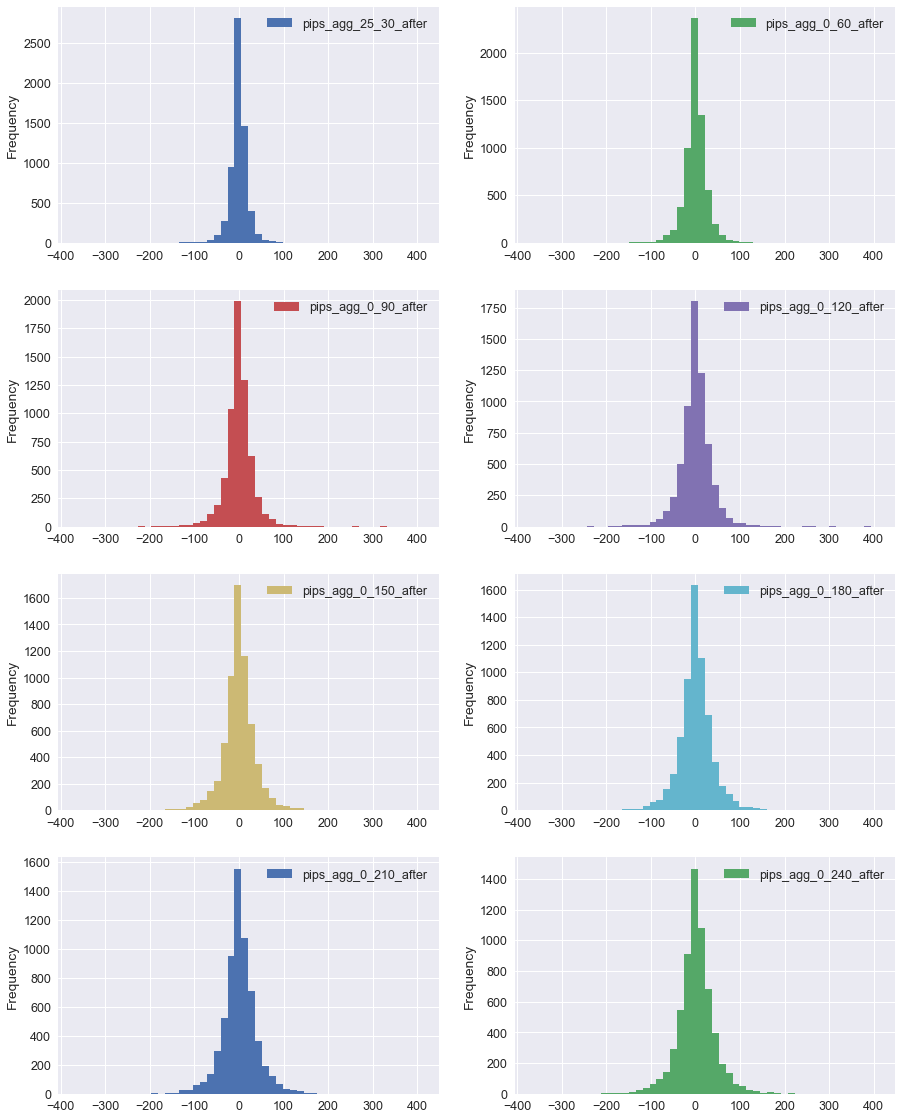

In [383]:
df_wo_outliers_by_datetime[df_wo_outliers_by_datetime.columns[1:]].plot(kind='hist', subplots=True, bins = 50, sharex=False, layout=(4,2),figsize=(15,20))

In [384]:
df_wo_outliers_by_datetime.describe()

,pips_agg_25_30_after,pips_agg_0_60_after,pips_agg_0_90_after,pips_agg_0_120_after,pips_agg_0_150_after,pips_agg_0_180_after,pips_agg_0_210_after,pips_agg_0_240_after
count,6301.000000,6301.000000,6301.000000,6301.000000,6301.000000,6301.000000,6301.000000,6301.000000
mean,-0.124266,-0.080146,-0.141406,0.204888,0.119505,0.523250,0.826377,0.952706
std,20.979876,26.111132,30.493853,34.255859,36.323789,38.199775,40.153147,42.117835
min,-164.000000,-184.000000,-220.000000,-229.000000,-199.000000,-306.000000,-337.000000,-367.000000
25%,-9.000000,-11.000000,-14.000000,-15.000000,-16.000000,-17.000000,-18.000000,-19.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,12.000000,14.000000,16.000000,17.000000,18.000000,20.000000,21.000000
max,294.000000,354.000000,331.000000,381.000000,366.000000,371.000000,409.000000,383.000000


**Observations**

- For all the considered snapshots, 50% of the times the market reaction is less than desired for investment. 
As a rule of thumb, anything above 20 pips could be useful for investment. Anything below is not worth it.
   
- The pattern observed after 30 minutes is reproduced after 4h, although pips increments/decrements seems to be higher, which is somehow expected.

Now, let´s see whether there is a correlation between reaction after 30 min and reaction after 60 min

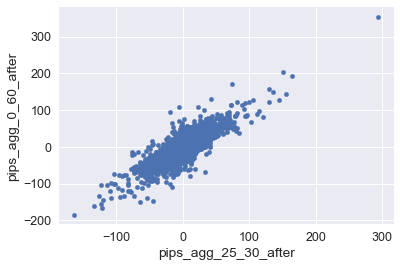

In [385]:
df_wo_outliers_by_datetime.plot.scatter(x='pips_agg_25_30_after', y='pips_agg_0_60_after')

Cool, it confirms our assumption that these two variables are correlated. This correlation seems to be linear.
Let´s do the same but looking after 4 hours

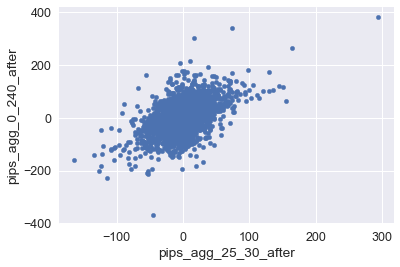

In [386]:
df_wo_outliers_by_datetime.plot.scatter(x='pips_agg_25_30_after', y='pips_agg_0_240_after')

Ok... More noise in this case... :-(

------------

### Relationship with the number of outliers in forecast-actual deviations 

First, let´s see how often we do have outliers 

In [388]:
df_pips_by_datetime = df_wo_outliers[['datetime_gmt','total_error_diff_oulier_class', 'pips_agg_25_30_after', 
                          'pips_agg_0_60_after', 'pips_agg_0_240_after']]

df_pips_by_datetime = df_pips_by_datetime.groupby('datetime_gmt', as_index=False).agg({'total_error_diff_oulier_class': 'sum',
                                                                                       'pips_agg_25_30_after': 'first',
                                                                                      'pips_agg_0_60_after': 'first',
                                                                                      'pips_agg_0_240_after': 'first'})



In [389]:
df_pips_by_datetime.head(2)

,datetime_gmt,total_error_diff_oulier_class,pips_agg_25_30_after,pips_agg_0_60_after,pips_agg_0_240_after
0,2007-01-08 20:00:00+00:00,0,0,-1,18
1,2007-01-09 15:00:00+00:00,0,5,-3,6


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


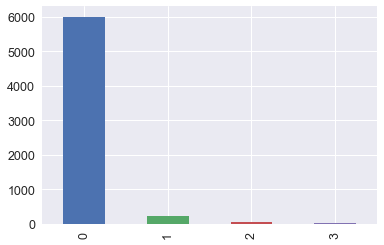

In [390]:
df_temp = df_pips_by_datetime[['total_error_diff_oulier_class']]
df_temp['ocurrences'] = 1
df_temp = df_temp.groupby('total_error_diff_oulier_class').sum().reset_index()
df_temp['ocurrences'].plot(kind='bar')

The frecuency of outliers in the deviation between forecast and actual is indeed pretty low.   
Experts seems to know what they are doing... :-D

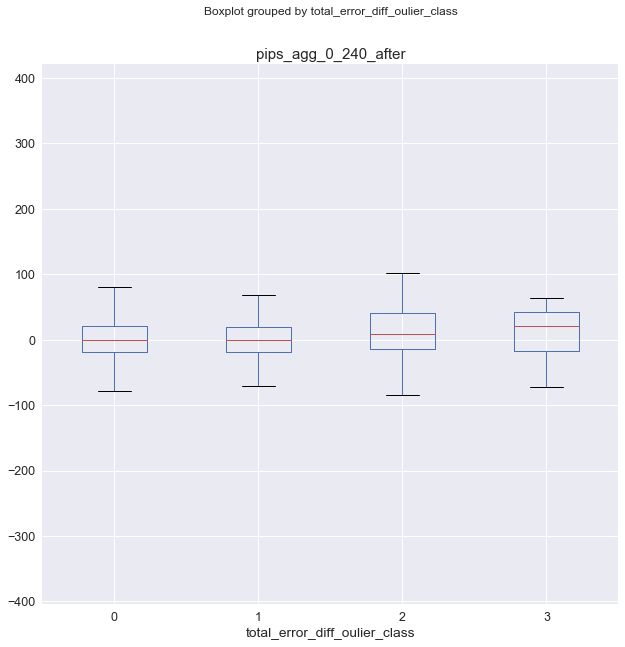

In [391]:
df_pips_by_datetime.boxplot(column='pips_agg_0_240_after', by='total_error_diff_oulier_class',
                           figsize=(10,10))


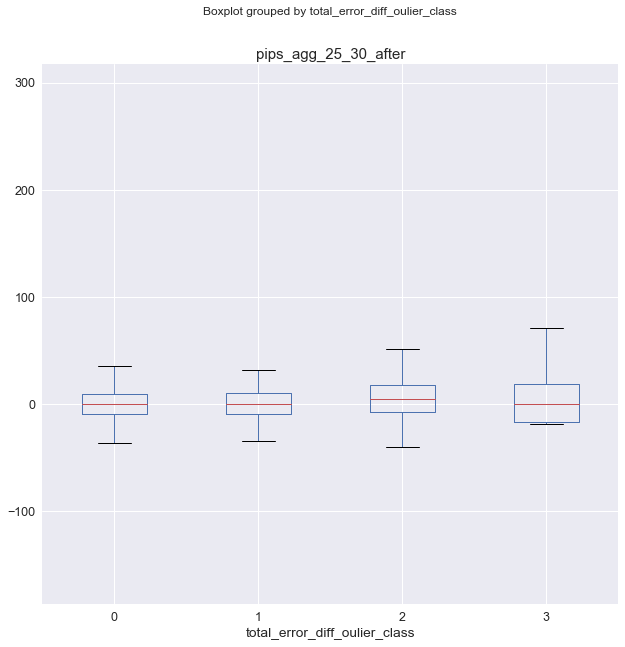

In [392]:
df_pips_by_datetime.boxplot(column='pips_agg_25_30_after', by='total_error_diff_oulier_class',
                           figsize=(10,10))



This analysis is not very accurate because of two reasons:

- Sizes of each group are not comparable between thems
- We have just summed up all the values without weighting them by the 'impact' category of the new. I.e. a high deviation in a new classified as having "HIGH" impact should move the market more than a high deviation in a new classified as "LOW"  
   
However, it´s good to see that, the more outliers, the higher (positive?) impact in pips.

### Relationship with deviation

In [399]:
df_wo_outliers.head(2)

,datetime_gmt,actual,country,datetime,forecast,forecast_error,impact,new,previous,previous_error,week,forecast_error_diff,year,quarter,month,weekday,volatility_60_0_before,pips_agg_60_0_before,volatility_0_45_after,pips_agg_0_45_after,volatility_0_60_after,pips_agg_0_60_after,volatility_0_90_after,pips_agg_0_90_after,volatility_0_120_after,pips_agg_0_120_after,volatility_0_150_after,pips_agg_0_150_after,volatility_0_180_after,pips_agg_0_180_after,volatility_0_210_after,pips_agg_0_210_after,volatility_0_240_after,pips_agg_0_240_after,open_released,high_released,low_released,close_released,high_0_5_after,low_0_5_after,close_0_5_after,volatility_0_5_after,direction_candle_0_5_after,direction_agg_0_5_after,pips_agg_0_5_after,pips_candle_0_5_after,high_5_10_after,low_5_10_after,close_5_10_after,volatility_5_10_after,...,volatility_10_15_after,direction_candle_10_15_after,direction_agg_10_15_after,pips_agg_10_15_after,pips_candle_10_15_after,high_15_20_after,low_15_20_after,close_15_20_after,volatility_15_20_after,direction_candle_15_20_after,direction_agg_15_20_after,pips_agg_15_20_after,pips_candle_15_20_after,high_20_25_after,low_20_25_after,close_20_25_after,volatility_20_25_after,direction_candle_20_25_after,direction_agg_20_25_after,pips_agg_20_25_after,pips_candle_20_25_after,high_25_30_after,low_25_30_after,close_25_30_after,volatility_25_30_after,direction_candle_25_30_after,direction_agg_25_30_after,pips_agg_25_30_after,pips_candle_25_30_after,previous_value,previous_error_diff,total_error_diff,forecast_error_diff_std,forecast_error_diff_dir,forecast_error_diff_deviation,forecast_error_diff_upper_quantile,forecast_error_diff_lower_quantile,forecast_error_diff_oulier_class,previous_error_diff_std,previous_error_diff_dir,previous_error_diff_deviation,previous_error_diff_upper_quantile,previous_error_diff_lower_quantile,previous_error_diff_oulier_class,total_error_diff_std,total_error_diff_dir,total_error_diff_deviation,total_error_diff_upper_quantile,total_error_diff_lower_quantile,total_error_diff_oulier_class
0,2007-01-08 20:00:00+00:00,12.3B,USD,2007-01-08 15:00:00,5.4B,better,Low,Consumer Credit m/m,-1.3B,accurate,2,6.9,2007,1,1,0,14,4,9,-2,9,-1,15,-1,18,3,21,5,23,8,23,8,32,18,13018,13020,13016,13018,13022,13016,13019,6,0,0,1,0,13020,13016,13017,4,...,9,0,0,1,1,13021,13017,13020,4,0,0,2,2,13022,13016,13018,6,0,0,0,-2,13020,13015,13018,5,0,0,0,0,-1.3B,0.0,6.9,6.9,-1.0,1.0,6.9,6.9,0,0.0,-1.0,0.0,0.0,0.0,0,6.9,-1.0,1.0,6.9,6.9,0
1,2007-02-07 20:00:00+00:00,6.0B,USD,2007-02-07 15:00:00,7.0B,worse,Low,Consumer Credit m/m,13.7B,better,6,-1.0,2007,1,2,2,15,-11,10,-2,11,5,16,7,16,7,16,7,17,6,17,9,23,14,13007,13008,13002,13005,13006,13003,13006,3,0,0,1,1,13010,13004,13005,6,...,5,0,0,0,-2,13005,13001,13005,4,0,0,0,2,13005,13000,13002,5,0,0,-3,-3,13006,13001,13005,5,0,0,0,0,12.3B,1.4,0.4,-1.0,1.0,-1.0,-1.0,-1.0,0,1.4,1.0,1.0,1.4,1.4,0,0.4,1.0,1.0,0.4,0.4,0


In [403]:
df_pips_by_datetime = df_wo_outliers[['datetime_gmt','forecast_error_diff_deviation', 'new','pips_agg_25_30_after', 
                          'pips_agg_0_60_after', 'pips_agg_0_240_after']]

df_pips_by_datetime = df_pips_by_datetime.groupby('datetime_gmt', as_index=False).agg({'forecast_error_diff_deviation': 'sum',
                                                                                       'new': 'count',
                                                                                       'pips_agg_25_30_after': 'first',
                                                                                      'pips_agg_0_60_after': 'first',
                                                                                      'pips_agg_0_240_after': 'first'})

df_pips_by_datetime = df_pips_by_datetime[df_pips_by_datetime['new'] == 1]

In [404]:
df_pips_by_datetime.describe()

,forecast_error_diff_deviation,new,pips_agg_25_30_after,pips_agg_0_60_after,pips_agg_0_240_after
count,4372.000000,4372.0,4372.000000,4372.000000,4372.000000
mean,0.007889,1.0,-0.006862,0.152790,1.581427
std,1.352066,0.0,19.009695,24.573199,40.357309
min,-5.940000,1.0,-134.000000,-166.000000,-367.000000
25%,-0.690000,1.0,-8.000000,-10.000000,-17.000000
50%,0.000000,1.0,0.000000,0.000000,1.000000
75%,0.770000,1.0,8.000000,11.000000,19.000000
max,5.960000,1.0,294.000000,354.000000,383.000000


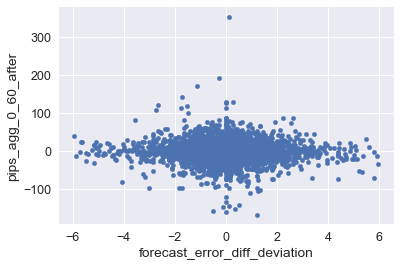

In [405]:
df_pips_by_datetime.plot.scatter(x='forecast_error_diff_deviation', y='pips_agg_0_60_after')

### Relationship with total deviation

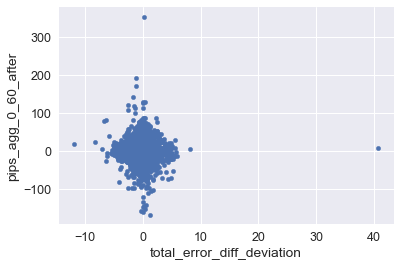

In [406]:
df_pips_by_datetime = df_wo_outliers[['datetime_gmt','total_error_diff_deviation', 'new','pips_agg_25_30_after', 
                          'pips_agg_0_60_after', 'pips_agg_0_240_after']]

df_pips_by_datetime = df_pips_by_datetime.groupby('datetime_gmt', as_index=False).agg({'total_error_diff_deviation': 'sum',
                                                                                       'new': 'count',
                                                                                       'pips_agg_25_30_after': 'first',
                                                                                      'pips_agg_0_60_after': 'first',
                                                                                      'pips_agg_0_240_after': 'first'})

df_pips_by_datetime = df_pips_by_datetime[df_pips_by_datetime['new'] == 1]
df_pips_by_datetime.plot.scatter(x='total_error_diff_deviation', y='pips_agg_0_60_after')

### Correlation matrix

In [418]:
list(df.columns)

['datetime_gmt',
 'actual',
 'country',
 'datetime',
 'forecast',
 'forecast_error',
 'impact',
 'new',
 'previous',
 'previous_error',
 'week',
 'forecast_error_diff',
 'year',
 'quarter',
 'month',
 'weekday',
 'volatility_60_0_before',
 'pips_agg_60_0_before',
 'volatility_0_45_after',
 'pips_agg_0_45_after',
 'volatility_0_60_after',
 'pips_agg_0_60_after',
 'volatility_0_90_after',
 'pips_agg_0_90_after',
 'volatility_0_120_after',
 'pips_agg_0_120_after',
 'volatility_0_150_after',
 'pips_agg_0_150_after',
 'volatility_0_180_after',
 'pips_agg_0_180_after',
 'volatility_0_210_after',
 'pips_agg_0_210_after',
 'volatility_0_240_after',
 'pips_agg_0_240_after',
 'open_released',
 'high_released',
 'low_released',
 'close_released',
 'high_0_5_after',
 'low_0_5_after',
 'close_0_5_after',
 'volatility_0_5_after',
 'direction_candle_0_5_after',
 'direction_agg_0_5_after',
 'pips_agg_0_5_after',
 'pips_candle_0_5_after',
 'high_5_10_after',
 'low_5_10_after',
 'close_5_10_after',
 'vo

In [408]:
columns_of_interest = [
 'forecast',
 'forecast_error',
 'impact',
 'new',
 'previous',
 'previous_error',
 'week',
 'forecast_error_diff',
 'year',
 'quarter',
 'month',
 'weekday',
 'volatility_60_0_before',
 'pips_agg_60_0_before',
 'volatility_0_45_after',
 'pips_agg_0_45_after',
 'volatility_0_60_after',
 'pips_agg_0_60_after',
 'volatility_0_90_after',
 'pips_agg_0_90_after',
 'volatility_0_120_after',
 'pips_agg_0_120_after',
 'volatility_0_150_after',
 'pips_agg_0_150_after',
 'volatility_0_180_after',
 'pips_agg_0_180_after',
 'volatility_0_210_after',
 'pips_agg_0_210_after',
 'volatility_0_240_after',
 'pips_agg_0_240_after',
 'volatility_0_5_after',
 'pips_agg_0_5_after',
 'pips_candle_0_5_after',
 'volatility_5_10_after',
 'pips_agg_5_10_after',
 'pips_candle_5_10_after',
 'volatility_10_15_after',
 'pips_agg_10_15_after',
 'pips_candle_10_15_after',
 'volatility_15_20_after',
 'pips_agg_15_20_after',
 'pips_candle_15_20_after',
 'volatility_20_25_after',
 'pips_agg_20_25_after',
 'pips_candle_20_25_after',
 'volatility_25_30_after',
 'pips_agg_25_30_after',
 'pips_candle_25_30_after',
 'previous_value',
 'previous_error_diff',
 'total_error_diff',
 'forecast_error_diff_deviation',
 'forecast_error_diff_oulier_class',
 'previous_error_diff_deviation',
 'previous_error_diff_oulier_class',
 'total_error_diff_deviation',
 'total_error_diff_oulier_class']

In [409]:
correlation_matrix = df_wo_outliers[columns_of_interest].corr()

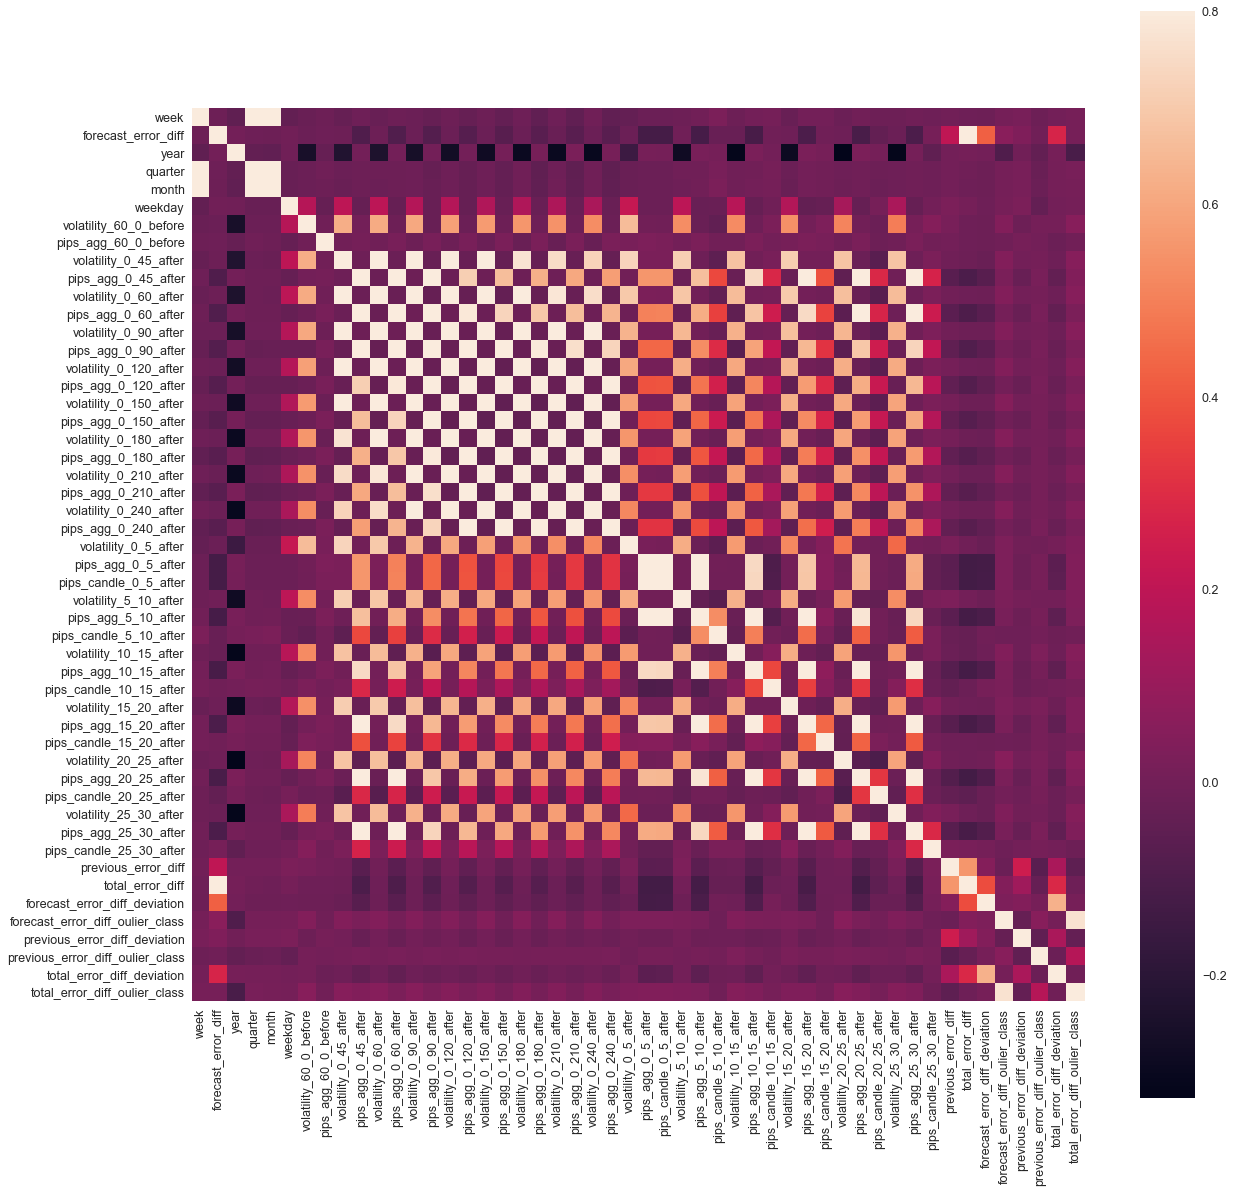

In [410]:
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(correlation_matrix, vmax=.8, square=True);

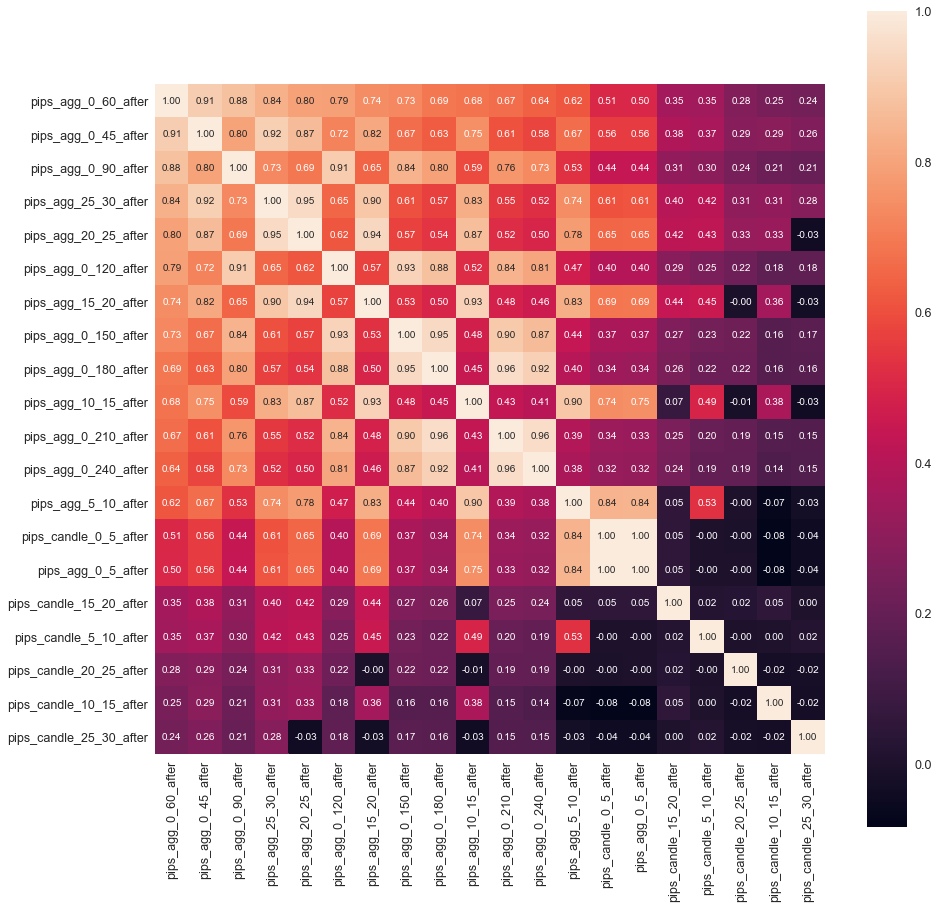

In [411]:
# pips_agg_0_60_after
k = 20 
cols = correlation_matrix.nlargest(k, 'pips_agg_0_60_after')['pips_agg_0_60_after'].index
cm = np.corrcoef(df[cols].values.T)
f, ax = plt.subplots(figsize=(15, 15))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Conclusions


- Low one-to-one correlation between features comming from the release of the new and the pips variation
- What happened after 4h is highly correlated with what happened after 30 minutes
- 20 pips seems to be a good threshold for classifying the impact as NONE, UP, DOWN
-
